<a href="https://colab.research.google.com/github/joseluisfalla/QA_JFALLA/blob/main/assingment_2/quantum_teleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Quantum Teleportation

In this module, we'll explore the quantum teleportation algorithm.

Suppose Alice wants to send information to Bob. Alice starts with a qubit state $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$, which means that the information she wants to send to Bob is encoded in $\alpha$ and $\beta$.

As you learned in lecture, you cannot make a copy an unknown quantum state (no-cloning theorem), so we have to be smart about using the quantum (and classical) resources we have at hand.

In short, by taking advantage of two classical bit and an entangled qubit pair, Alice can transfer her state $|\psi\rangle$ to Bob. This ends up being a quantum teleportation protocol since, in the end, Bob will have $|\psi\rangle$ and Alice will not.

In [1]:
# Let's begin with the usual installs and imports
!pip install qiskit

In [2]:
!pip install qiskit_aer
%pip install pylatexenc

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit_aer import Aer

In [4]:
# For our setup, we need 3 qubits in the quantum register and 2 classical bits in the classical register.
qr = QuantumRegister(3, name='q')
crz = ClassicalRegister(1, name='crz')
crx = ClassicalRegister(1, name='crx')
# Notice here that we are actually separating the classical register into two classical registers.
# Also, as you see, we can name the registers so that we see their labels when we print the circuit.
# Now, we can build the circuit with our registers:
teleportation_circuit = QuantumCircuit(qr, crz, crx)

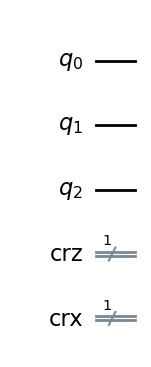

In [5]:
# Let's see what the circuit looks like so far.
teleportation_circuit.draw('mpl')

The first step is for a third party, Charlie, to create an entangled pair of qubits and give one of those qubits to Alice and the other one to Bob.

The entangled qubit pair that Charlie creates is a special type of entangled qubit pair called a [Bell pair](https://en.wikipedia.org/wiki/Bell_state). Now, the way to create this Bell pair is to first transfer one of the qubits into the Hadamard basis and then apply a CNOT gate, where the control qubit is the qubit in the Hadamard basis.

In [6]:
# Write a function that creates a Bell pair between two qubits
# Your code here:
def create_bell_pair(qc, a, b):
  qc.h(a)
  qc.cx(a, b)

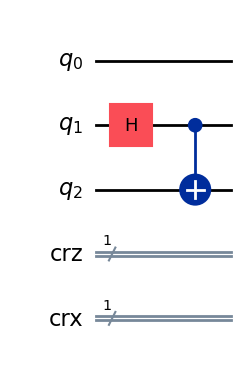

In [7]:
# Now, apply the Bell pair function to the circuit and see what it looks like.
# Let's assume that Charlie entagles qubits 1 and 2, and that qubit 0 is the one to teleport.
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw('mpl')

After Charlie entangles the qubits, he gives Alice qubit 1 and Bob qubit 2.

The next step is for Alice to apply a CNOT gate to qubit 1, using her quantum state $|\psi\rangle$ as the control qubit, followed by a Hadamard gate.

In [8]:
def alice_gates(qc, psi, a):
  qc.cx(psi, a)
  qc.h(psi)

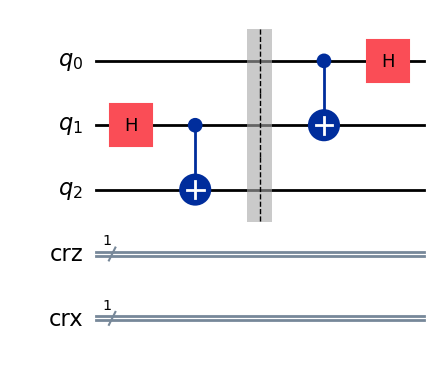

In [9]:
# Let's apply Alice's gates and see what the circuit looks like now.
teleportation_circuit.barrier() # The .barrier() syntax allows us to separate steps in a circuit. It's very useful when trying to visualize a circuit step by step.
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

The third step in the protocol is for Alice to make a measurement on both her quantum state $|\psi\rangle$ and the qubit she received from Charlie ($q_{1}$) and store those values on the classical register. Alice will send these classical bits to Bob.

In [10]:
def measure_and_send(qc, a, b):
  qc.barrier()
  qc.measure(a, 0)
  qc.measure(b, 1)

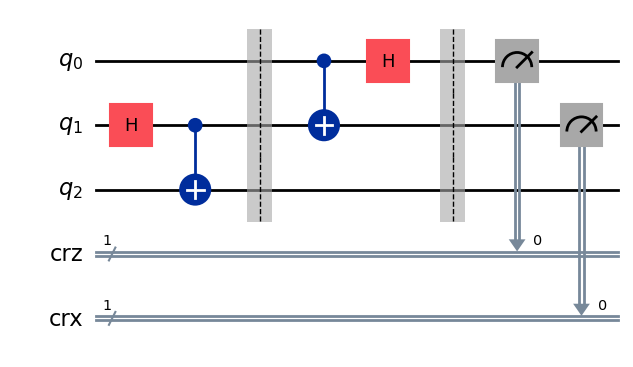

In [11]:
# Again, let's see our circuit so far.
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw('mpl')

Now, we move to Bob's side of things. Depending on the classical bits he receives from Alice, he performs the following operations:



*   00 $→$ Do nothing
*   01 $→$ Apply X gate
*   10 $→$ Apply Z gate
*   11 $→$ Apply ZX gate


In [12]:
def bob_gates(qc, qubit, crz, crx):
  # Here we see another method we can use with Qiskit: conditional gates with the .c_if() syntax.
  qc.x(qubit).c_if(crx, 1)
  qc.z(qubit).c_if(crz, 1)

<ipython-input-12-a41c3a18266c>:3: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qubit).c_if(crx, 1)
<ipython-input-12-a41c3a18266c>:4: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qubit).c_if(crz, 1)


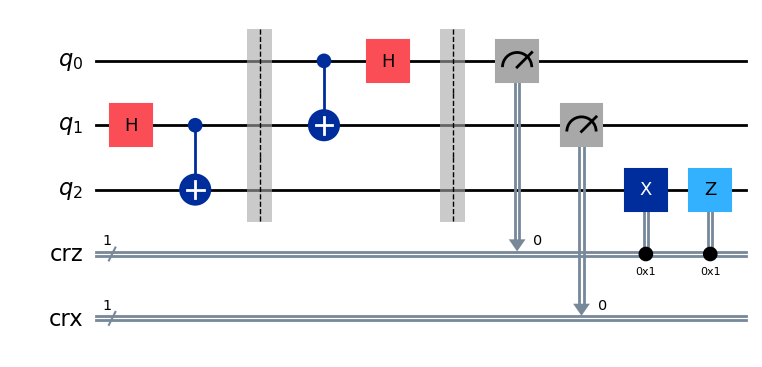

In [13]:
# Apply Bob's gates and visualize the circuit.
bob_gates(teleportation_circuit, 2, crz, crz) # Remember that Bob's qubit is q_2.
teleportation_circuit.draw('mpl')

And that is pretty much it for the circuit. Alice has effectively teleported her quantum state $|\psi\rangle$ to Bob. But we're not done yet...

## 2. Simulating the Teleportation Protocol

So far, the teleportation algorithm from above has Alice's qubit initialized to the computational state $|0\rangle$. This is not very interesting, so we should initialize Alice's qubit in a random state $|\psi\rangle$. We will use the ''Initialize'' gate on $|q_{0}\rangle$.

In [14]:
# Here I'm going to violate PEP8, but I'd rather have the imports here to make it less confusing.
from qiskit.circuit.library import Initialize
from qiskit.quantum_info import random_statevector

In [29]:
psi = random_statevector(2) # The argument that random_statevector() takes is the dimensions of the state. So, for a single qubit, it's 2.

<IPython.core.display.Latex object>

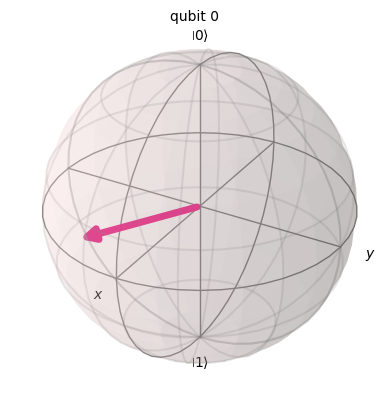

In [30]:
# Before proceeding, let's visualize this random state in the Block sphere.
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Now we can define our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$.

In [31]:
init_gate = Initialize(psi)
init_gate.label = "init"

NB. ''Initalize'' is technically not a gate since it contains a reset operation, so it is not reversible. In this context, we call it an ''instruction''.

Now that we have our initial random state, we can check to see if our algorithm works. The way we'll check is by doing a statevector simulation and seeing that, in fact, the state $|\psi\rangle$ is teleported to Bob's qubit $q_{2}$.

<ipython-input-12-a41c3a18266c>:3: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qubit).c_if(crx, 1)
<ipython-input-12-a41c3a18266c>:4: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qubit).c_if(crz, 1)


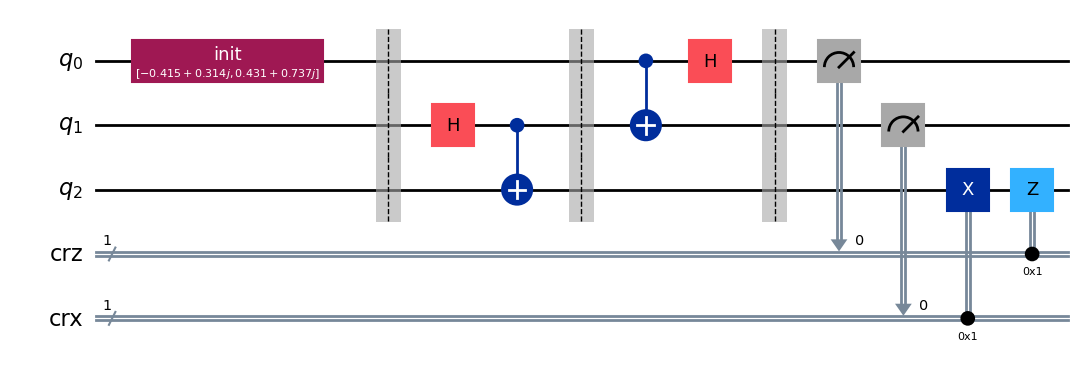

In [32]:
# Re-write the setup, including the random initialization
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# STEP 0: Initialize Alice's q_0
teleportation_circuit.append(init_gate, [0])
teleportation_circuit.barrier()

# STEP 1: Begin the teleportation protocol
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()

# STEP 2: Send q_1 to Alice and q_2 to Bob
alice_gates(teleportation_circuit, 0, 1)

# STEP 3: Alice sends classical bits to Bob
measure_and_send(teleportation_circuit, 0, 1)

# STEP 4: Bob decodes qubits
bob_gates(teleportation_circuit, 2, crz, crx)

# Display the circuit
teleportation_circuit.draw('mpl')

What we really want to see here is the final statevector. In order to do that, we'll save the statevector from the simulation.

In [33]:
backend = Aer.get_backend('statevector_simulator')

In [34]:
result = backend.run(teleportation_circuit).result()

In [35]:
statevector = result.get_statevector(teleportation_circuit)

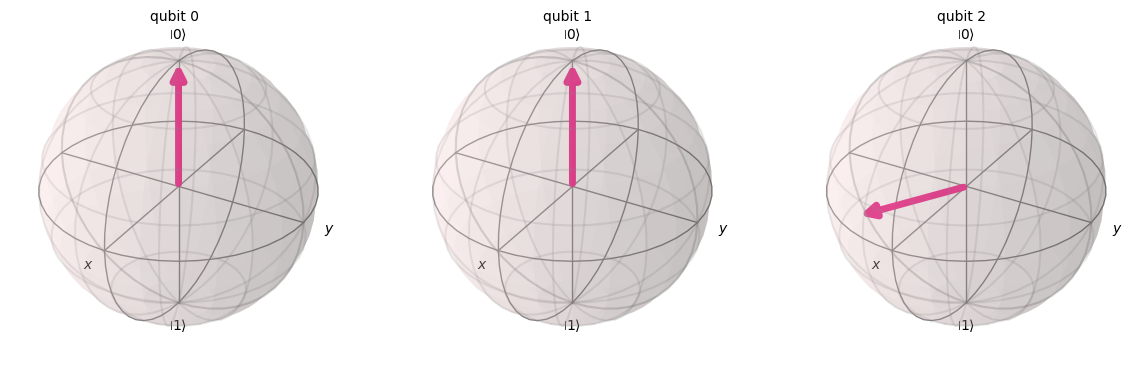

In [36]:
plot_bloch_multivector(statevector)

Run this circuit a few times. What do you notice about qubits 0, 1, and 2?

## Your answer here

## 3. Simulated Counts

We cannot really test for **actual** quantum teleportation in this module. What we'll do instead is demonstrate that the gates we apply perform the correct transformations on a single quantum chip.

On a real quantum computer, we would not be able to sample the statevector. So, in order to check for teleportation, we can do an "inverse" to our "Initialization" on Bob's qubit ($q_{2}$), which should give us state $|0\rangle$ deterministically.

More, specifically, the Initialize instruction performs:
$|0\rangle \rightarrow |\psi\rangle$, by applying a set of gates (we do not really see these gates in our circuit).

Therefore, the first step is to get this set of gates to find a disentangler, which is simply the set of inverses of these gates.

In [37]:
inverse_init_gate = init_gate.gates_to_uncompute() # This gives us the inverse of our initialization gates

The "inverse_init_gate" will perform: $|\psi\rangle →|0\rangle$.

<ipython-input-12-a41c3a18266c>:3: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qubit).c_if(crx, 1)
<ipython-input-12-a41c3a18266c>:4: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qubit).c_if(crz, 1)


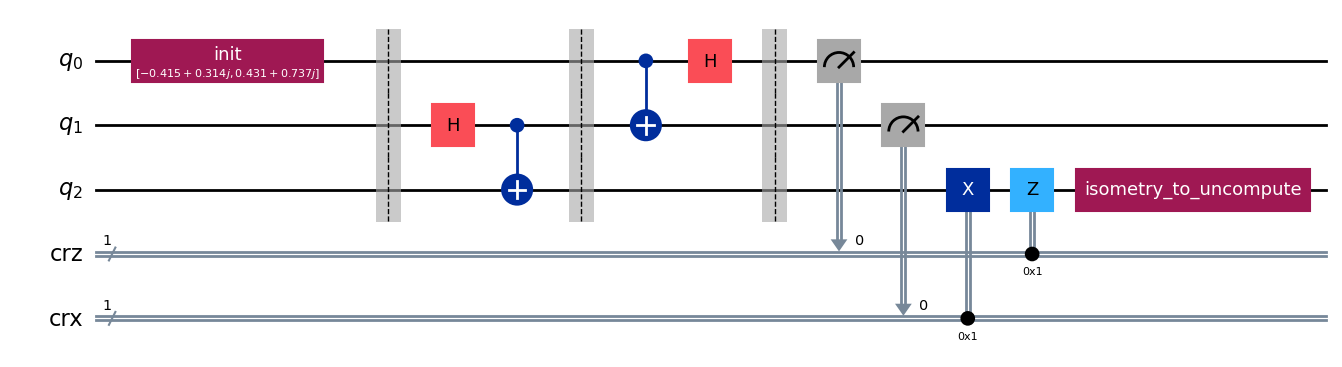

In [39]:
# Re-write the setup, including the random initialization
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# STEP 0: Initialize Alice's q_0
teleportation_circuit.append(init_gate, [0])
teleportation_circuit.barrier()

# STEP 1: Begin the teleportation protocol
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()

# STEP 2: Send q_1 to Alice and q_2 to Bob
alice_gates(teleportation_circuit, 0, 1)

# STEP 3: Alice sends classical bits to Bob
measure_and_send(teleportation_circuit, 0, 1)

# STEP 4: Bob decodes qubits
bob_gates(teleportation_circuit, 2, crz, crx)

# STEP 5: Disentangle
teleportation_circuit.append(inverse_init_gate, [2])

# Display the circuit
teleportation_circuit.draw('mpl')

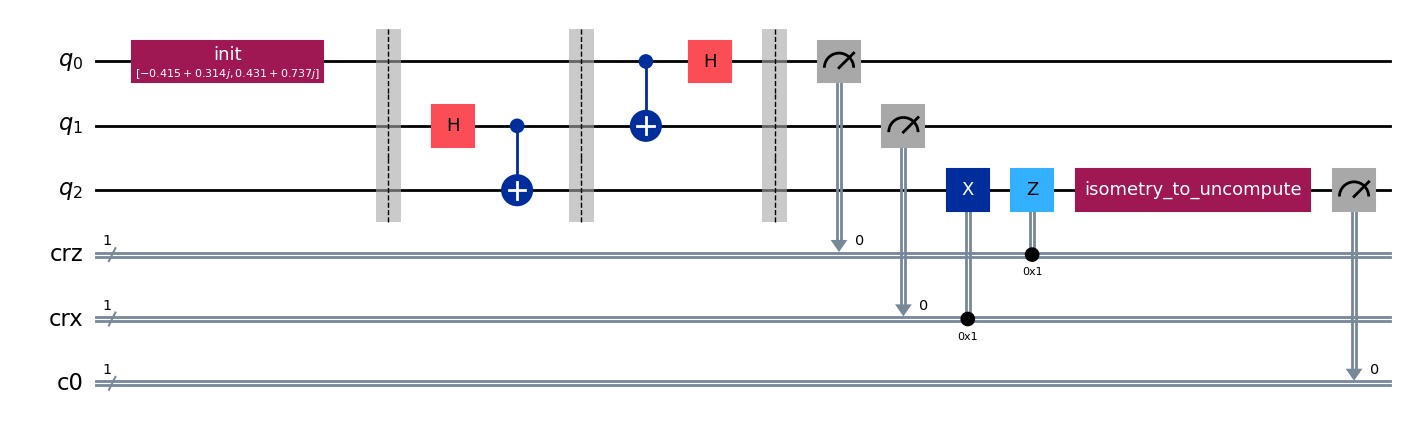

In [40]:
# We need to add a classical register to perform a measurement on q_2
# YOUR CODE HERE

cr_result = ClassicalRegister(1)
teleportation_circuit.add_register(cr_result)
teleportation_circuit.measure(2,2)

# Draw the circuit
teleportation_circuit.draw('mpl')

In [43]:
# Now run the circuit and get the counts
backend = Aer.get_backend('statevector_simulator')
job = backend.run(transpile(teleportation_circuit, backend), shots=1024)
result = job.result()
counts = result.get_counts()

Since we are only interested in seeing that, in fact, Bob's qubit always returns a measurement of 0, we can use qiskit's marginal_counts function. To understand more about marginal counts, refer to the documentation [here](https://docs.quantum.ibm.com/api/qiskit/result).

In [46]:
# Another PEP8 violation :V
from qiskit.result import marginal_counts

In [47]:
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]

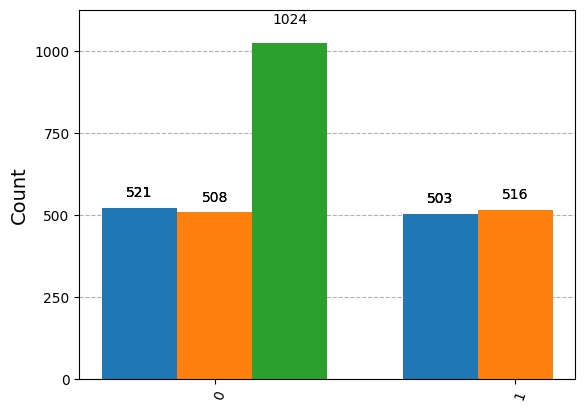

In [48]:
plot_histogram(qubit_counts)

In the figure above we see that Bob's qubit always returns a measurement of 0, as expected.

## Possible Questions


*   It might seem that quantum teleportation violates faster-than-light communication. Why is this not the case?
*   List item

